# Advance Lane Detection Project Report
***

## Goals and Objectives
---

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

In [1]:
import cv2
import os
import matplotlib.pyplot as plt
%matplotlib inline

## Camera Calibration
---

I start by preparing "object points", which will be the (x, y, z) coordinates of the chessboard corners in the world. Here I am assuming the chessboard is fixed on the (x, y) plane at z=0, such that the object points are the same for each calibration image.  Thus, `objp` is just a replicated array of coordinates, and `object_points` will be appended with a copy of it every time I successfully detect all chessboard corners in a test image and `img_points` will be appended with the (x, y) pixel position of each of the corners in the image. The code tries to find a chessboard pattern of 6 rows and 9 columns and if it fails, try to search for a chessboard pattern of 5 rows and 9 columns. I then used the output `obj_points` and `img_points` to compute the camera calibration and distortion coefficients using the `cv2.calibrateCamera()` function.

The code for the same has been implemented in _./utils/cameraCalibration.py_ (check function `get_calibration_matrix()`)

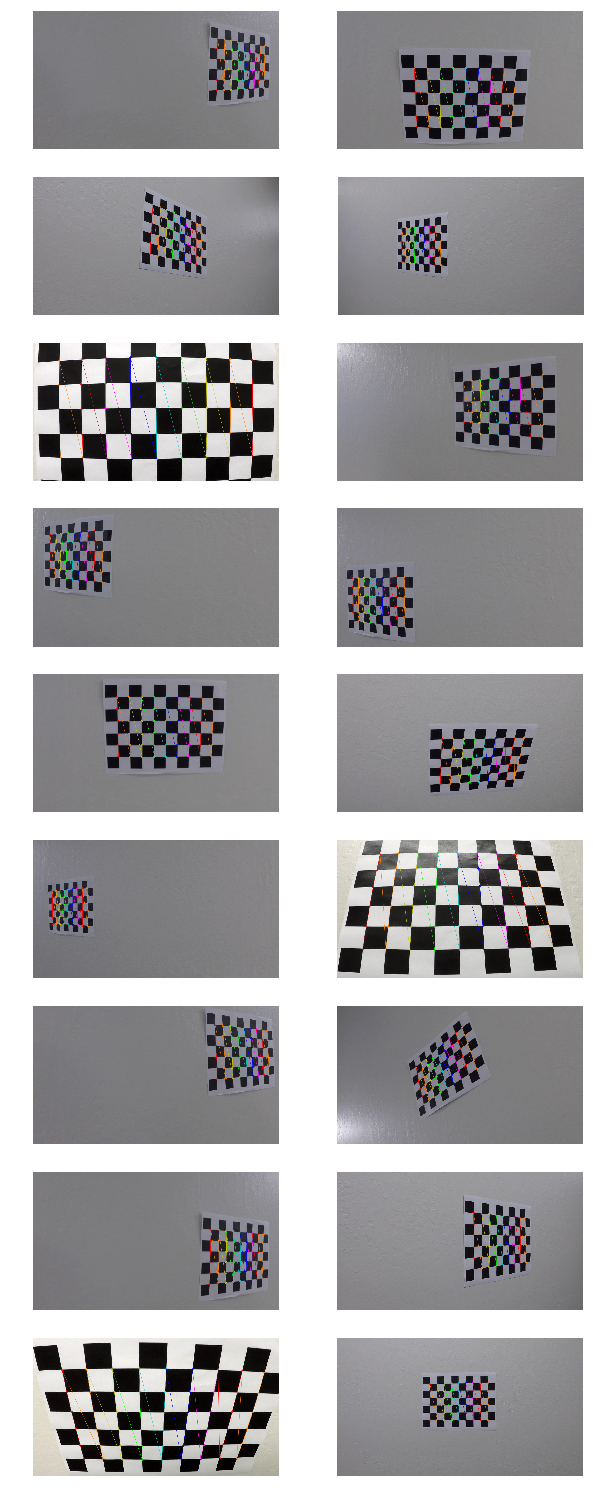

In [2]:
from utils import cameraCalibration
(ret, cameraMat, distCoeffs, rvecs, tvecs), fig = cameraCalibration.get_calibration_matrix(os.path.join('camera_cal','*.jpg'))
fig.set_size_inches(10,30)

I then use `cv2.undistort` function (check function `undistort()` in _./utils/cameraCalibration.py_) and obtained the following result:

([], <a list of 0 Text yticklabel objects>)

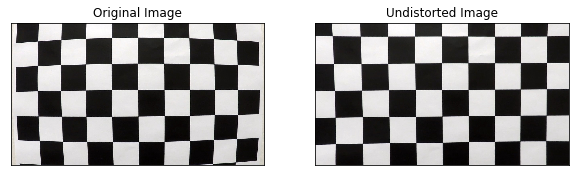

In [3]:
test_image = plt.imread(os.path.join('camera_cal', 'calibration1.jpg'))
undistorted_img = cameraCalibration.undistort(test_image, cameraMat, distCoeffs)


plt.figure(figsize=(10,40))
plt.subplot(121)
plt.imshow(test_image)
plt.title('Original Image')
plt.xticks([])
plt.yticks([])

plt.subplot(122)
plt.imshow(undistorted_img)
plt.title('Undistorted Image')
plt.xticks([])
plt.yticks([])




## Pipeline (single images)
---

### 1. Undistoring a Image 

Using `camMat` and `distCoeffs` found in previous step of camera calibration, the raw image from the video is undistorted using `cv2.undistort` function. Following is an eaxmple of undistorted image:

([], <a list of 0 Text yticklabel objects>)

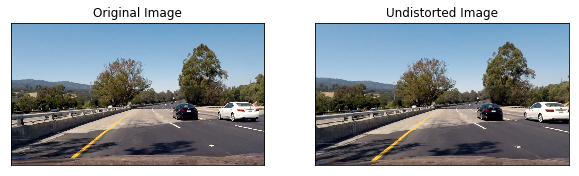

In [4]:
test_image = plt.imread(os.path.join('test_images', 'test4.jpg'))
undistorted_img = cameraCalibration.undistort(test_image, cameraMat, distCoeffs)


plt.figure(figsize=(10,40))
plt.subplot(121)
plt.imshow(test_image)
plt.title('Original Image')
plt.xticks([])
plt.yticks([])

plt.subplot(122)
plt.imshow(undistorted_img)
plt.title('Undistorted Image')
plt.xticks([])
plt.yticks([])

### 2. Image Thresholding
I then use `threshold` function (in _./utils/thresholding.py_) to threshold white and yellow color pixels from HLS channels. The following image shows area threshold by yellow mask and red color shows area thresholded by white mask.

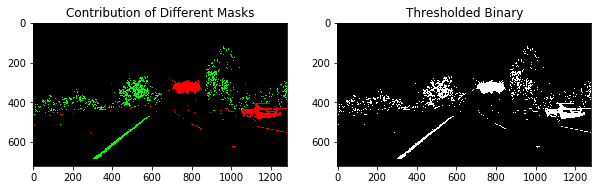

In [5]:
from utils.thresholding import *

plt.figure(figsize=(10,40))
plt.subplot(1,2,1)
thresholded = threshold(test_image, color=True)
plt.imshow(thresholded)
plt.title('Contribution of Different Masks')

plt.subplot(1,2,2)
b_thresholded = threshold(test_image)
plt.imshow(b_thresholded, cmap='gray')
plt.title('Thresholded Binary')

### 2. Perspective Transformation
The perspective transformation was done using following source and destination points.

Source Points:
```
 [  588.   446.]
 [  691.   446.]
 [ 1126.   673.]
 [  153.   673.]
```

Destination Points:
```
 [  200.     0.]
 [ 1080.     0.]
 [ 1080.   720.]
 [  200.   720.]
```

The output after the perspective transform for the thresholded binary is as shown below:

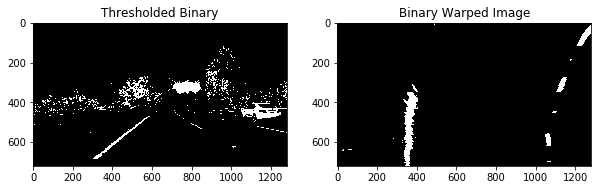

In [6]:
img_size = (b_thresholded.shape[1], b_thresholded.shape[0])
width, height = img_size
offset = 200
src = np.float32([
    [  588,   446 ],
    [  691,   446 ],
    [ 1126,   673 ],
    [  153 ,   673 ]])
dst = np.float32([[offset, 0], [img_size[0] - offset, 0], [img_size[0] - offset, img_size[1]], [offset, img_size[1]]])
M = cv2.getPerspectiveTransform(src,dst)
Minv = cv2.getPerspectiveTransform(dst, src)

plt.figure(figsize=(10,40))
plt.subplot(1,2,1)
b_thresholded = threshold(test_image)
plt.imshow(b_thresholded, cmap='gray')
plt.title('Thresholded Binary')

plt.subplot(1,2,2)
binary_warped = cv2.warpPerspective(b_thresholded,M, (width, height))
plt.imshow(binary_warped, cmap='gray')
plt.title('Binary Warped Image')

### 3. Lane Detections
I am adding up the pixel values along each column in the image. In my thresholded binary image, pixels are either 0 or 1, so the two most prominent peaks in this histogram will be good indicators of the x-position of the base of the lane lines. I then use that as a starting point for where to search for the lines with margin of `100px` and considering `1/9th` of the image starting from bottom.

Once one of the first frames is processed, I use the last known line location to restrict my search for new lane pixels. The code for the same can be found in _./utils/pipeline.py_.

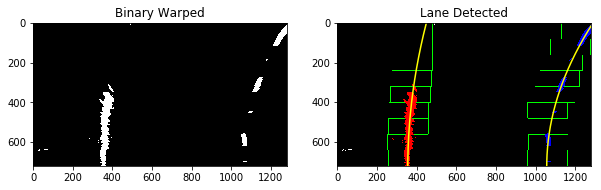

In [7]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Take a histogram of the bottom half of the image
histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)

# Create an output image to draw on and  visualize the result
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255

# Finding peak of the left and right halves of the histogram
# These will be the starting point for the left and right lines
midpoint = np.int(histogram.shape[0]/2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

# Number of sliding windows
nwindows = 9

# Height of windows
window_height = np.int(binary_warped.shape[0]/nwindows)

# Identifing the x and y positions of all nonzero pixels in the image
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])


# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base

# Margin in which to search
margin = 100

# Minimum number of pixels found to recenter window
minpix = 50

# Empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

# Steping through windows one by one
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = binary_warped.shape[0] - (window+1)*window_height
    win_y_high = binary_warped.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    
    # Drawing the windows on the visualization image
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
    cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
    
    # Identifing the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
    
    # Appending these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    
    # Recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

# Concatenating the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extracting left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

## Visualization
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

plt.figure(figsize=(10,40))
plt.subplot(1,2,1)
plt.imshow(binary_warped, cmap='gray')
plt.title('Binary Warped')

plt.subplot(1,2,2)
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)
plt.title('Lane Detected')

### 3. Radius of Curvature
If real-world corrdinate (subscript x<sub>real</sub> and y<sub>real</sub>) are related to coordinate in pixel space (x<sub>pix</sub> and y<sub>pix</sub>) by some multiplier, the radius of curvature for real world co-ordinate can be calculated as shown below:

<img src="images/combined.png" alt="Radius Of Curvature" style="width: 300px;"/>

The radius of curvature for the above image comes out to be `888.142m`. 

In [21]:
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])

ym_per_pix = 3.0/72.0 # meters per pixel in y dimension
xm_per_pix = 3.7/660.0 # meters per pixel in x dimension

y_eval = np.max(ploty/2)*ym_per_pix

midx = 650

y1 = (2*left_fitx[0]*y_eval + left_fitx[1])*xm_per_pix/ym_per_pix
y2 = 2*left_fitx[0]*xm_per_pix/(ym_per_pix*ym_per_pix)

curvature = ((1 + y1*y1)**(1.5))/np.absolute(y2)
print("Radius of Curvature: %f" % curvature)

Radius of Curvature: 2250097.069136


### 4. Plotting back the Identified lanes on Image

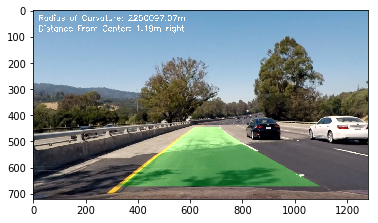

In [22]:
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
newwarp = cv2.warpPerspective(color_warp, Minv, (undistorted_img.shape[1], undistorted_img.shape[0])) 

# Combine the result with the original image
result = cv2.addWeighted(undistorted_img, 1, newwarp, 0.3, 0)

cv2.putText(result,'Radius of Curvature: %.2fm' % curvature,(20,40), cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,255),2)

x_left_pix = left_fit[0]*(y_eval**2) + left_fit[1]*y_eval + left_fit[2]
x_right_pix = right_fit[0]*(y_eval**2) + right_fit[1]*y_eval + right_fit[2]
position_from_center = ((x_left_pix + x_right_pix)/2 - midx) * xm_per_pix
if position_from_center < 0:
    text = 'left'
else:
    text = 'right'
cv2.putText(result,'Distance From Center: %.2fm %s' % (np.absolute(position_from_center), text),(20,80), cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,255),2)
plt.imshow(result)

# Final Video
---

The final video of the pipeline implementation can be accessed [here](https://youtu.be/pC7CRrP74iQ). To smoothen out the output, the weigths for the polynomial fit are updated as weight of previously detected lines. For implemetation details check `./utils/line.py`.

The video of the final output can be viewed as - project_video_output.mp4

In [23]:
from utils.pipeline import Pipeline
from utils.line import Line
from moviepy.editor import VideoFileClip
from IPython.display import HTML

line=Line()
print ("first frame processes:",line.first_frame_processed)
line.first_frame_processed=0;

Pipeline.set_values(line, M, Minv, cameraMat, distCoeffs)

white_output = 'project_video_output.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(Pipeline.pipeline)
%time white_clip.write_videofile(white_output, audio=False)

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

first frame processes: None
[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 1260/1261 [02:00<00:00, 10.46it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 5min 11s, sys: 4.9 s, total: 5min 16s
Wall time: 2min 1s


# Discussion
---
The code does not perform quite well on challenge videos as the creation of binary image does not encapsulate the lanes under varied illumination color shades in challenge videos. The pipeline could be made more robust by normalizing image (using histogram equilization or CLAHE) to account for illumination variations.

Manually tuning parameters for Computer Vision pipeline was extremely tedious. The project made me realize the significance of Machine Learning and Deeplearning based approach used in the previous project for behaviour cloning.